# Quelle est l'empreinte écologique de notre assiette ? 

### Traitement des données "Agribalyse"

*Camille Gaborieau, Jérome Pivard et Blanche Lalouette*

# **I/ RECUPERATION DES DONNEES ET NETTOYAGE DE LA BASE**

## 1) Récupération des données 

In [5]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

Nous avons récupéré 5 tableaux différents : 
* df_synthèse réunit les informations les plus importantes de tous les autres, en attribuant un score écologique à 2479 produits français 
* df_ingrédients rentre plus en détail sur les aliments composants les produits cités plus haut
* df-étape retrace le chemin de nos ingrédients depuis l'agriculture jusqu'au supermarché 
* df_agri_nonbio et df_agri_bio détaillent l'empreinte écologique due à l'agriculture respectivement non biologique et biologique des produits traitées dans les tableaux précédents. 

In [6]:
df_synt = pd.read_csv ("Agribalyse-Synthese.csv")
df_ingredients = pd.read_csv("Agribalyse_Detail ingredient.csv")
df_etapes = pd.read_csv("Agribalyse_Detail etape.csv")
df_agriculture = pd.ExcelFile("AGRIBALYSE3_partie agriculture.xlsx")
df_agri_1 = pd.read_excel(df_agriculture,"AGB_agri",header = 1)
df_agri_2 = pd.read_excel(df_agriculture, "AGB organic product", header=1)

En guise d'exemple, voici quelques informations sur notre premier tableau : 

In [7]:
print(df_synt[["Code AGB","Nom du Produit en Français","Groupe d'aliment","Sous-groupe d'aliment", "Saisonnalité", "Matériau d'emballage","Livraison","Préparation"]].nunique())

Code AGB                      2479
Nom du Produit en Français    2479
Groupe d'aliment                11
Sous-groupe d'aliment           58
Saisonnalité                     3
Matériau d'emballage            19
Livraison                        5
Préparation                      8
dtype: int64


* 2479 aliments différents (qui ont bien tous un nom différent)
* 11 groupes et 55 sous-groupes d'aliments différents
* 3 types de saisonnalité
* Transport par avion est une variable indicatrice
* 5 modalités de livraison
* 11 types de préparation
* 19 matériaux d'emballage
* 14 indicateurs d'impact environnemental

## 2) Nettoyage des données 

*Procédons désormais à un nettoyage de nos tableaux. Il s'agit de retirer les valeurs manquantes, enlever les colonnes inutiles (nom anglais des produits, inducateurs peu robustes), et renommer les colonnes de façon plus parlante.*

### a) Tableau de synthèse

*Pour le nettoyage de cette base, nous avons pour le moment adopté deux approches différentes, et avons donc deux tableaux différents avec les mêmes données, nous verrons lequel sera le plus adapté ensuite aux traitements que nous ferons: un tableau extrêmement synthétique, et un tableau avec un nettoyage plus allégé.*

In [12]:
df_synthese = df_synt.dropna()
df_synthese

,Code AGB,Code CIQUAL,Groupe d'aliment,Sous-groupe d'aliment,Nom du Produit en Français,LCI Name,Livraison,Matériau d'emballage,Préparation,DQR - Note de qualité de la donnée (1 excellente ; 5 très faible),...,Eutrophisation terreste (mol N eq/kg de produit),Eutrophisation eaux douces (E-03 kg P eq/kg de produit),Eutrophisation marine (E-03 kg N eq/kg de produit),Utilisation du sol (Pt/kg de produit),Écotoxicité pour écosystèmes aquatiques d'eau douce (CTUe/kg de produit),Épuisement des ressources eau (m3 depriv./kg de produit),Épuisement des ressources énergétiques (MJ/kg de produit),Épuisement des ressources minéraux (E-06 kg Sb eq/kg de produit),Saisonnalité,Transport par avion (1 : par avion)
1141,20061_1,20061.0,"fruits, légumes, légumineuses et oléagineux",légumes,"Haricot vert importé par avion, cru","French bean by plane, raw",Ambiant (moyenne),Pas d'emballage,Réfrigéré chez le consommateur,2.52,...,0.205713,0.387346,19.106720,119.063840,83.567205,8.106421,154.41530,2.575316,mix de consommation FR,1.0
1355,13025_1,13025.0,"fruits, légumes, légumineuses et oléagineux",fruits,"Mangue importée par avion, pulpe, crue","Mango by plane, pulp, raw",Ambiant (moyenne),Pas d'emballage,Pas de préparation,2.79,...,0.274655,0.487313,24.256069,32.048403,206.260910,17.622634,218.49787,3.906755,mix de consommation FR,1.0


In [ ]:
df_synthese.drop(['Code CIQUAL', 'LCI Name'], axis='columns', inplace=True) 

In [8]:
#On ne garde que les données qui ont un DQR (data quality ratio)plus faible qu'un certain seuil (3 par exemple) car “La Commission Européenne recommande de la prudence dans l’utilisation des données avec des DQR supérieurs à 3. Dans la base de données AGRIBALYSE, 67 % des données ont un DQR jugé bon ou très bon (1 à 3).” Garder deux tiers des données est suffisant pour avoir des résultats intéressants et un champ assez étendu.
df_synthese = df_synthese [df_synthese["DQR - Note de qualité de la donnée (1 excellente ; 5 très faible)"]<=3].copy()

#On peut ne garder que celle dépassant un certain seuil (par exemple 1) au niveau de l'impact (par exemple au sens de l'indicateur précédent qui est à la fois l'un des plus robustes et l'un des plus parlants), pour éviter de considérer des aliments dont l'impact est finalement assez faible. Avantage : plus synthétique / Inconvénient : Perte d'information (compensée par notre deuxième nettoyage "allégé" du même tableau)
df_synthese_tronque_impact = df_synthese[df_synthese['Changement climatique (kg CO2 eq/kg de produit)']>1].copy()

#On choisit de ne garder que trois indicateurs d'impact environnemental (parmi les plus robustes) pour faire les premiers calculs : changement climatique, acidification, appauvrissement de la couche d'ozone. De plus, le score unique (indicateur composite qui calcule un impact pondéré fonction de tous les indicateurs selon leurs robustesses respectives) garantit qu'il n'y a pas de perte d'information.
df_synthese_reduit_indicateurs = df_synthese_tronque_impact [["Groupe d'aliment","Sous-groupe d'aliment",'Nom du Produit en Français','Livraison',"Matériau d'emballage",'Préparation','Score unique EF (mPt/kg de produit)','Changement climatique (kg CO2 eq/kg de produit)',"Appauvrissement de la couche d'ozone (E-06 kg CVC11 eq/kg de produit)","Acidification terrestre et eaux douces (mol H+ eq/kg de produit)",'DQR - Note de qualité de la donnée (1 excellente ; 5 très faible)']]

#On s'aperçoit qu'il y a des doublons dans les noms des produits, on aimerait ne garder qu'une seule ligne par produit de même appelation. On peut y remédier en s'assurant que chaque produit du tableau a par exemple une valeur différente d'impact sur le changement climatique (on aurait pu le faire aussi avec n'importe quel autre indicateur).
df_synthese_propre_1 = df_synthese_reduit_indicateurs.drop_duplicates(subset = ['Changement climatique (kg CO2 eq/kg de produit)']).sort_values("Groupe d'aliment").reset_index(drop=True)
df_synthese_propre_1

In [25]:
#Procédons désormais au nettoyage plus allégé: 
df_synthese.drop(["Code AGB"], axis = "columns", inplace = True)

#on supprime les aliments ayant un DQR trop élevé (les données recueillies sont peu fiables, cf infra)
df_synthese = df_synthese[df_synthese["DQR - Note de qualité de la donnée (1 excellente ; 5 très faible)"].between(1,3)]
df_synthese_propre_2= df_synthese.sort_values("Score unique EF (mPt/kg de produit)", ascending=False)
#On a ainsi un deuxième tableau, beaucoup plus riche en informations mais qui a pour inconvénient d'être moins lisible. Les aliments sont classés en fonction de leur "score unique", i.e. de leur impact environnemental pondéré par indicateur.

df_synthese_propre_2

,Groupe d'aliment,Sous-groupe d'aliment,Nom du Produit en Français,Livraison,Matériau d'emballage,Préparation,DQR - Note de qualité de la donnée (1 excellente ; 5 très faible),Score unique EF (mPt/kg de produit),Changement climatique (kg CO2 eq/kg de produit),Appauvrissement de la couche d'ozone (E-06 kg CVC11 eq/kg de produit),...,Eutrophisation terreste (mol N eq/kg de produit),Eutrophisation eaux douces (E-03 kg P eq/kg de produit),Eutrophisation marine (E-03 kg N eq/kg de produit),Utilisation du sol (Pt/kg de produit),Écotoxicité pour écosystèmes aquatiques d'eau douce (CTUe/kg de produit),Épuisement des ressources eau (m3 depriv./kg de produit),Épuisement des ressources énergétiques (MJ/kg de produit),Épuisement des ressources minéraux (E-06 kg Sb eq/kg de produit),Saisonnalité,Transport par avion (1 : par avion)
1355,"fruits, légumes, légumineuses et oléagineux",fruits,"Mangue importée par avion, pulpe, crue",Ambiant (moyenne),Pas d'emballage,Pas de préparation,2.79,1.244447,14.898319,3.418751,...,0.274655,0.487313,24.256069,32.048403,206.260910,17.622634,218.49787,3.906755,mix de consommation FR,1.0
1141,"fruits, légumes, légumineuses et oléagineux",légumes,"Haricot vert importé par avion, cru",Ambiant (moyenne),Pas d'emballage,Réfrigéré chez le consommateur,2.52,0.835217,10.316175,2.376467,...,0.205713,0.387346,19.106720,119.063840,83.567205,8.106421,154.41530,2.575316,mix de consommation FR,1.0


### b) Tableau sur les ingrédients 

Pour ce tableau, on n'a pas d'information sur la qualité des données. Cette fois, on garde un maximum de données (même si l'impact de l'ingrédient est faible) afin d'obtenir la décomposition la plus fine possible de l'impact environnemental du produit, en fonction des différents ingrédients et au sens des différents indicateurs (on ne garde que les plus robustes comme précédemment, sachant que le score unique contient toute l'information).

In [8]:
df_ingredients = df_ingredients.dropna()
df_ingredients.drop(['Ciqual AGB', 'LCI Name'], axis='columns', inplace=True)
df_ingredients = df_ingredients [['Ingredients','Nom Français',"Groupe d'aliment","Sous-groupe d'aliment",'Score unique EF (mPt/kg de produit)','Changement climatique (kg CO2 eq/kg de produit)',"Appauvrissement de la couche d'ozone (E-06 kg CVC11 eq/kg de produit)","Acidification terrestre et eaux douces (mol H+ eq/kg de produit)"]]
df_ingredients.head(5)

,Ingredients,Nom Français,Groupe d'aliment,Sous-groupe d'aliment,Score unique EF (mPt/kg de produit),Changement climatique (kg CO2 eq/kg de produit),Appauvrissement de la couche d'ozone (E-06 kg CVC11 eq/kg de produit),Acidification terrestre et eaux douces (mol H+ eq/kg de produit)
0,Jaune d'œuf,"Sauce aïoli, préemballée",aides culinaires et ingrédients divers,sauces,0.039743,0.164754,0.014089,0.006761
1,Ail,"Sauce aïoli, préemballée",aides culinaires et ingrédients divers,sauces,0.004417,0.011444,0.002512,0.000105
2,Jus de citron,"Sauce aïoli, préemballée",aides culinaires et ingrédients divers,sauces,0.019375,0.061230,0.007842,0.000951
3,Huile d'olive,"Sauce aïoli, préemballée",aides culinaires et ingrédients divers,sauces,0.445364,1.161825,0.136467,0.021524
4,Autres étapes,"Sauce aïoli, préemballée",aides culinaires et ingrédients divers,sauces,0.080761,0.571172,0.126768,0.002630


### c) Tableau sur les étapes du cycle de vie du produit

*Le nettoyage est résolument similaire à celui du dataframe df_synthese. On commence d'abord par enlever les données manquantes et les colonnes redondantes du dataframe. En particulier, les dernières colonnes détaillent la construction du DQR global, ce qui n'est pas primordial pour le traitement que nous souhaitons faire des données.*

In [9]:
df_etapes = df_etapes.dropna()
df_etapes.drop(["Code CIQUAL", "LCI Name", "Groupe d'aliment", "Nom et code","DQR - P", "DQR - TiR", "DQR - GR", "DQR - TeR"], axis='columns', inplace=True)

#On remarque que les indicateurs précédemment triés se séparent entre six catégories correspondant aux six étapes du cycle de vie des aliments étudiés. Afin de pouvoir exploiter le dataframe, nous le simplifions en ne gardant que les scores uniques correspondant à chaque étape, et en créant un score unique moyen (regroupant toutes les étapes, mais sans pondération des étapes pour simplifier).Nous ne conservons ainsi que le dataframe contenant les éléments essentiels de présentation des aliments ainsi que ces indicateurs synthétiques.
df_etapes["Score unique EF (mPt / kg de produit)-Moyenne"] = (df_etapes["Score unique EF (mPt / kg de produit) - Agriculture"] + df_etapes["Score unique EF (mPt / kg de produit) - Transformation"] + df_etapes["Score unique EF (mPt / kg de produit) - Emballage"] + df_etapes["Score unique EF (mPt / kg de produit) - Transport"] + df_etapes["Score unique EF (mPt / kg de produit) - Supermarché et distribution"] + df_etapes["Score unique EF (mPt / kg de produit) - Consommation"])/6
df_etapes = df_etapes[["Sous-groupe d'aliment",'Nom du Produit en Français',"Score unique EF (mPt / kg de produit)-Moyenne", "Score unique EF (mPt / kg de produit) - Agriculture", "Score unique EF (mPt / kg de produit) - Transformation", "Score unique EF (mPt / kg de produit) - Emballage", "Score unique EF (mPt / kg de produit) - Transport","Score unique EF (mPt / kg de produit) - Supermarché et distribution", "Score unique EF (mPt / kg de produit) - Consommation","DQR"]]

#A nouveau, on ne garde que les données qui ont un DQR (data quality ratio) plus faible que 3 (voir supra pour la justification du seuil).
df_etapes = df_etapes[df_etapes["DQR"]<=3].copy()

#De même, nous supprimons les doublons dans les noms des produits afin de conserver qu'une seule ligne par produit de même appellation (on s'assure que chaque produit du tableau a une valeur différente de score unique).
df_etapes = df_etapes.drop_duplicates(subset = ['Score unique EF (mPt / kg de produit)-Moyenne'])

#Finalement, nous classons comme précédemment les données en fonction du sous-groupe d'aliment. 
df_etapes_propre = df_etapes.sort_values("Sous-groupe d'aliment", ascending = True).copy()
df_etapes_propre = df_etapes_propre.reset_index(drop=True)
df_etapes_propre.head(5)

,Sous-groupe d'aliment,Nom du Produit en Français,Score unique EF (mPt / kg de produit)-Moyenne,Score unique EF (mPt / kg de produit) - Agriculture,Score unique EF (mPt / kg de produit) - Transformation,Score unique EF (mPt / kg de produit) - Emballage,Score unique EF (mPt / kg de produit) - Transport,Score unique EF (mPt / kg de produit) - Supermarché et distribution,Score unique EF (mPt / kg de produit) - Consommation,DQR
0,aides culinaires,"Préparation culinaire à base de soja, type ""cr...",0.031080,0.094796,0.049300,0.016462,0.016024,0.009899,0.000000,2.09
1,algues,"Kombu ou kombu japonais (Laminaria japonica), ...",0.210055,0.667595,0.532574,0.022225,0.019454,0.017959,0.000522,2.99
2,algues,"Agar (algue), cru",0.208762,0.667595,0.532574,0.022225,0.019454,0.010205,0.000522,2.99
3,autres matières grasses,"Lard gras, cru",0.033827,0.145793,0.015529,0.015547,0.014042,0.009620,0.002429,2.11
4,autres matières grasses,Graisse de canard,0.033433,0.142160,0.016160,0.015547,0.014683,0.009620,0.002429,2.96


### d) Données sur les produits bruts 

*On s'aperçoit qu'il y a un décalage dans les premières lignes, on va donc supprimer la ligne en trop (avec les noms des unités, que l'on reporte dans la première ligne). Enlevons toutes les colonnes inutiles avant de renommer les autres et de clarifier le décalage de lignes.*

In [10]:
df_agri_normal= pd.read_excel(df_agriculture,"AGB_agri", header=1)

df_agri_normal.drop(['Unnamed: 1', 'Climate change - fossil', 'Climate change - biogenic','Climate change - land use and transform.'], axis='columns', inplace=True)
df_agri_nonbio = df_agri_normal.rename(columns={'Unnamed: 0':'Nom du produit', 'Unnamed: 2':'Catégorie', 'Climate change': 'Changement climatique (en eq. kg CO2)', 'Ozone depletion': 'Appauvrissement de la couche d ozone (en eq. kg CFC11)','Ionising radiation, HH':'Rayonnements ionisants, effet sur la santé (en eq. kBq U-235)', 'Photochemical ozone formation, HH':'Formation d ozone photochimique (en eq. kg NMVOC)', 'Respiratory inorganics':'Substances inorganiques respiratoires (incidence de maladie)', 'Acidification terrestrial and freshwater':'Acidification (eq. mol H+)', 'Eutrophication freshwater': 'Eutrophisation eau douce (en eq. kg P)', 'Eutrophication marine':'Eutrophisation marine (en eq. kg N)', 'Eutrophication terrestrial':'Eutrophisation terrestre (en eq. mol N)', 'Ecotoxicity freshwater':'Ecotoxicité d eau douce (en CTUe)', 'Land use': 'Usage des terres (en Pt)', 'Water scarcity':'Epuisement des ressources en eau (en m3 Eau)', 'Resource use, energy carriers': 'Epuisement des ressources énergétiques (en MJ)', 'Resource use, mineral and metals': 'Epuisement des ressources minéraux (en eq. kg Sb)'}).copy()

df_agri_nonbio.drop([0],inplace = True)

#Cependant, comme nous l'avons vu, certains indicateurs sont très peu robustes. Enlevons les de nos données.
df_agri_nonbio.drop(["Usage des terres (en Pt)","Ecotoxicité d eau douce (en CTUe)", "Epuisement des ressources énergétiques (en MJ)","Epuisement des ressources minéraux (en eq. kg Sb)", "Epuisement des ressources en eau (en m3 Eau)"], axis ="columns", inplace=True)

df_agri_nonbio.head(5)

,Nom du produit,Catégorie,Changement climatique (en eq. kg CO2),Appauvrissement de la couche d ozone (en eq. kg CFC11),"Rayonnements ionisants, effet sur la santé (en eq. kBq U-235)",Formation d ozone photochimique (en eq. kg NMVOC),Substances inorganiques respiratoires (incidence de maladie),Acidification (eq. mol H+),Eutrophisation eau douce (en eq. kg P),Eutrophisation marine (en eq. kg N),Eutrophisation terrestre (en eq. mol N)
1,"Poulet, Bleu Blanc Coeur, at farm gate/FR U",Agricultural\Animal production\Avian\Transform...,1.44744,1.11454e-07,0.170576,0.00462458,3.2014e-07,0.0472122,0.000409922,0.0121022,0.206126
2,"Poulet, conventionnel, départ ferme / FR U",Agricultural\Animal production\Avian\Transform...,1.87453,1.45069e-07,0.219829,0.00632978,3.38427e-07,0.0493909,0.000515423,0.011752,0.212471
3,"Poulet, Label Rouge, à la de la ferme / FR U",Agricultural\Animal production\Avian\Transform...,2.82659,2.12771e-07,0.282615,0.0088557,5.4779e-07,0.0800916,0.000695502,0.0192948,0.346505
4,"Poulet, moyenne nationale, à la de la ferme /...",Agricultural\Animal production\Avian\Transform...,1.99191,1.53468e-07,0.227954,0.00664452,3.64812e-07,0.0532605,0.000538273,0.0127541,0.229395
5,"Canard à rôtir, conventionnel, à la ferme / FR U",Agricultural\Animal production\Avian\Transform...,2.73995,1.77542e-07,0.259452,0.00804329,6.45601e-07,0.0940418,0.000629109,0.017566,0.411137


On procède exactement de la même manières pour les produits brut biologiques 

In [11]:
df_agri_organic= pd.read_excel(df_agriculture,"AGB organic product", header=1)
df_agri_organic.drop(['Unnamed: 1', 'Climate change - fossil', 'Climate change - biogenic', 'Climate change - land use and transform.'], axis ="columns", inplace= True )
df_agri_bio = df_agri_organic.rename(columns={'Unnamed: 0':'Nom du produit', 'Unnamed: 2':'Catégorie', 'Climate change': 'Changement climatique (en eq. kg CO2)', 'Ozone depletion': 'Appauvrissement de la couche d ozone (en eq. kg CFC11)','Ionising radiation, HH':'Rayonnements ionisants, effet sur la santé (en eq. kBq U-235)', 'Photochemical ozone formation, HH':'Formation d ozone photochimique (en eq. kg NMVOC)', 'Respiratory inorganics':'Substances inorganiques respiratoires (incidence de maladie)', 'Acidification terrestrial and freshwater':'Acidification (eq. mol H+)', 'Eutrophication freshwater': 'Eutrophisation eau douce (en eq. kg P)', 'Eutrophication marine':'Eutrophisation marine (en eq. kg N)', 'Eutrophication terrestrial':'Eutrophisation terrestre (en eq. mol N)', 'Ecotoxicity freshwater':'Ecotoxicité d eau douce (en CTUe)', 'Land use': 'Usage des terres (en Pt)', 'Water scarcity':'Epuisement des ressources en eau (en m3 Eau)', 'Resource use, energy carriers': 'Epuisement des ressources énergétiques (en MJ)', 'Resource use, mineral and metals': 'Epuisement des ressources minéraux (en eq. kg Sb)'}).copy()
df_agri_bio.drop([0], inplace = True)
df_agri_bio.drop(["Usage des terres (en Pt)","Ecotoxicité d eau douce (en CTUe)", "Epuisement des ressources énergétiques (en MJ)","Epuisement des ressources minéraux (en eq. kg Sb)", "Epuisement des ressources en eau (en m3 Eau)"], axis ="columns", inplace=True)

df_agri_bio.head(5)

,Nom du produit,Catégorie,Changement climatique (en eq. kg CO2),Appauvrissement de la couche d ozone (en eq. kg CFC11),"Rayonnements ionisants, effet sur la santé (en eq. kBq U-235)",Formation d ozone photochimique (en eq. kg NMVOC),Substances inorganiques respiratoires (incidence de maladie),Acidification (eq. mol H+),Eutrophisation eau douce (en eq. kg P),Eutrophisation marine (en eq. kg N),Eutrophisation terrestre (en eq. mol N)
1,"Poulet, biologique, à la ferme / FR U",Agricultural\Animal production\Avian\Transform...,2.50144,2.00028e-07,0.338122,0.00865668,5.90742e-07,0.0865018,0.000763565,0.0311399,0.380357
2,"Poulet, biologique, système n ° 1, à la ferme ...",Agricultural\Animal production\Avian\Transform...,3.36722,2.23134e-07,0.370369,0.00973865,6.40683e-07,0.0967691,0.00110792,0.0358753,0.41902
3,"Poulet, biologique, système n ° 2, à la ferme ...",Agricultural\Animal production\Avian\Transform...,3.35622,2.19161e-07,0.346624,0.00997517,6.26829e-07,0.095043,0.00112005,0.0373553,0.411431
4,"poule Réforme, porte biologique, à la ferme / ...",Agricultural\Animal production\Avian\Transform...,4.92108,4.28126e-07,0.878833,0.0134483,8.59302e-07,0.12478,0.00104827,0.0239226,0.536996
5,"Réforme poule, biologique, système n ° 1, à la...",Agricultural\Animal production\Avian\Transform...,9.14596,7.24577e-07,1.27946,0.0284353,2.1249e-06,0.309146,0.00228231,0.0577689,1.34246


# II/ TRAITEMENTS SUR LES DONNEES ET DATA VISUALISATION

## 1) Tableau de synthèse très synthétique 


### a) Statistiques toutes familles de produits confondues

*On commence par faire quelques statistiques descriptives sur les données, afin d'avoir une idée de l'impact environnemental des produits considérés*

In [12]:
df_synthese_propre_1.mean()

NameError: name 'df_synthese_propre_1' is not defined

On obtient l'impact environnemental moyen sur tous les produits, qui servira de référence pour comparer l'impact de certains produits particuliers. La moyenne la plus significative est le score unique moyen, qui prend en compte tous les indicateurs et les pondère selon leur robustesse, ce score moyen est de 0,79 environ. Notons que le DQR moyen est proche de 2,5 : cela signifie que les données conservées sont en moyenne assez fiables (on vérifiera quand même plus loin que les éventuelles différences de DQR ne biaisent pas nos résultats).

Ne nous limitons pas à la moyenne et regardons les principales statistiques descriptives, sur le score unique seulement pour commencer.

,Score unique EF (mPt/kg de produit)
count,2.000000
mean,1.039832
std,0.289370
min,0.835217
25%,0.937524
50%,1.039832
75%,1.142140
max,1.244447


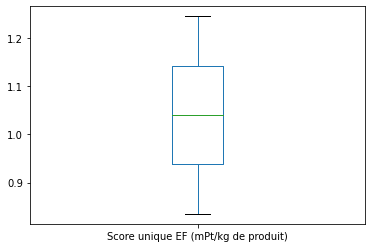

In [36]:
df_synthese_propre_1[["Score unique EF (mPt/kg de produit)"]].describe()
df_synthese_propre_1[["Score unique EF (mPt/kg de produit)"]].plot(kind="box")

Principaux constats :

* Les scores moyens s'étendent de 0,11 à 6,09 : il y a donc des aliments qui polluent largement plus que la moyenne (plus de sept fois plus que la moyenne pour le plus polluant) et d'autres beaucoup moins (idem, rapport relatif autour de 7).
* Les quartiles suggèrent que la distribution n'est pas très régulière,ce qu'illustre la boxplot précédente. En particulier, la médiane est nettement sous la moyenne (score médiane : à peine 60% du score moyen ), ce qui suggère que certaines valeurs extrêmes poussent la moyenne vers le haut. En d'autres termes, la moitié des produits ont un score unique inférieur à 0,45 (ce qui semble assez faible, mais ne signifie pas grand chose pour le moment), trois quarts ont un score unique inférieur à 0,85 (c'est-à-dire peu supérieur à la moyenne !) mais quelques aliments relativement très polluants tirent la moyenne vers le haut, il s'agit maintenant de les repérer.

In [37]:
df_synthese_propre_1[["Score unique EF (mPt/kg de produit)"]].quantile(q = [0.8,0.9,0.95])

,Score unique EF (mPt/kg de produit)
0.80,1.162601
0.90,1.203524
0.95,1.223986


On voit que seuls 5% des scores uniques sont au-dessus de 2,78 (i.e. un peu plus de trois fois le score moyen), cela confirme qu'un petit nombre d'aliments a un impact fort. Repérons les.

In [ ]:
produits_fort_impact_classes = produits_fort_impact.sort_values('Score unique EF (mPt/kg de produit)',ascending = False)
produits_fort_impact_classes.reset_index(drop=True).head(10)

Sur les 37 aliments considérés, trois seulement ont un score unique supérieur à six (et largement supérieur aux suivants) et ils contiennent tous de l'agneau. Derrière on retrouve essentiellement des produits à base de viande, mais il y a aussi les deux exceptions, arrivant en 14ème et 16ème place (c'est-à-dire assez haut !).

Lorsque l'on y regarde de plus près, on voit que ces deux aliments sans viande impactent surtout l'environnement en contribuant à appauvrir la couche d'ozone (plus que les aliments avec viande qui ont surtout un indicateur "Changement climatique" élevé). Comparons d'ailleurs le classement précédent avec le classement en fonction de l'indicateur "appauvrissement de la couche d'ozone".

In [ ]:
produits_fort_impact_classes_ozone = produits_fort_impact.sort_values("Appauvrissement de la couche d'ozone (E-06 kg CVC11 eq/kg de produit)",ascending = False)
produits_fort_impact_classes_ozone.reset_index(drop=True).head(10)

Ce classement confirme l'hypothèse précédente, surtout pour les nouilles : c'est bien leur impact sur la couche d'ozone qui les propulse dans le haut du classement. Travailler avec les données des autres tableaux devrait permettre de comprendre quelle étape du cycle de vie du produit explique cet impact. Pour les pêches, c'est un peu moins net ; il serait donc intéressant de regarder les autres indicateurs.

On peut encore classer ces aliments à fort impact selon d'autres critères, comme l'état dans lequel il est livré (livraison), le matériau d'emballage, la préparation...

On observe qu'à part la pêche qui est livrée à température ambiante, tout le reste est livré glacé.

In [ ]:
produits_fort_impact_classement_livraison = produits_fort_impact.sort_values("Livraison",ascending = False)
produits_fort_impact_classement_livraison.reset_index(drop=True).head(10)

In [10]:
produits_fort_impact_classement_emballage = produits_fort_impact.sort_values("Matériau d'emballage",ascending = False)
produits_fort_impact_classement_emballage.reset_index(drop=True).head(10)

,Groupe d'aliment,Sous-groupe d'aliment,Nom du Produit en Français,Livraison,Matériau d'emballage,Préparation,Score unique EF (mPt/kg de produit),Changement climatique (kg CO2 eq/kg de produit),Appauvrissement de la couche d'ozone (E-06 kg CVC11 eq/kg de produit),Acidification terrestre et eaux douces (mol H+ eq/kg de produit),DQR - Note de qualité de la donnée (1 excellente ; 5 très faible)
0,"fruits, légumes, légumineuses et oléagineux",légumes,"Haricot vert importé par avion, cru",Ambiant (moyenne),Pas d'emballage,Réfrigéré chez le consommateur,0.835217,10.316175,2.376467,0.055054,2.52
1,"fruits, légumes, légumineuses et oléagineux",fruits,"Mangue importée par avion, pulpe, crue",Ambiant (moyenne),Pas d'emballage,Pas de préparation,1.244447,14.898319,3.418751,0.074669,2.79


In [ ]:
produits_fort_impact_classement_preparation = produits_fort_impact.sort_values("Préparation",ascending = False)
produits_fort_impact_classement_preparation.reset_index(drop=True).head(10)

***Remarque*** : Pour voir à quel point les disparités en termes de DQR influent sur le score unique moyen (et donc sur l'impact environnemental observé), on aurait pu faire les mêmes statistiques en nous restreignant aux données les plus fiables (DQR inférieur au DQR moyen pour avoir assez de données i.e. à 2,5). Pas utile en fait, car lorsqu'on regarde les aliments les plus polluants, on voit que les DQR sont fluctuants entre 2 et 3, ce qui suggère qu'il n'y a pas de biais dans la fiabilité des données pour les aliments à fort impact.

Regardons également rapidement les produits à faible impact (on ne s'y intéressera plus beaucoup ensuite, à part peut-être pour imaginer des repas plus "soutenables" sur le plan environnemental). Fixons le seuil à la moitié de la valeur médiane du score unique (soit environ 0,25). Attention : on n'avait retiré les aliments ayant le plus faible impact sur le changement climatique, donc il faut aussi regarder le tableau de synthèse plus complet.

In [ ]:
produits_faible_impact = df_synthese_propre_1[df_synthese_propre_1["Score unique EF (mPt/kg de produit)"]<0.25].sort_values("Score unique EF (mPt/kg de produit)")
produits_faible_impact.head(5)

Cette fois, on s'aperçoit que les aliments à faible impact appartiennent à des groupes d'aliments assez variés, on va donc adopter une autre approche : comparer en classant par groupe d'aliment.

### b) Statistiques sur des groupes d'aliments précis

*L'idée de cette partie est de comparer l'impact environnemental d'aliments de la même famille, notamment dans le but de voir comment nous pouvons rendre nos repas plus respectueux de l'environnement (par substitution avec un aliment proche i.e. de la même famille).*

In [40]:
df_synthese_propre_3=df_synthese_propre_1.copy()
df_synthese_propre_3.drop(["Changement climatique (kg CO2 eq/kg de produit)", "Appauvrissement de la couche d'ozone (E-06 kg CVC11 eq/kg de produit)","Acidification terrestre et eaux douces (mol H+ eq/kg de produit)", "DQR - Note de qualité de la donnée (1 excellente ; 5 très faible)"], axis='columns', inplace=True)

#Commençons par effectuer les mêmes statistiques descriptives que tout à l'heure, mais pour chaque groupe d'aliment cette fois. On se concentre sur le score unique.
df_synthese_propre_3.groupby("Groupe d'aliment").describe()

Score unique EF (mPt/kg de produit)  \
                                                                          count   
Groupe d'aliment                                                                  
fruits, légumes, légumineuses et oléagineux                                 2.0   

                                                                          \
                                                 mean      std       min   
Groupe d'aliment                                                           
fruits, légumes, légumineuses et oléagineux  1.039832  0.28937  0.835217   

                                                                          \
                                                  25%       50%      75%   
Groupe d'aliment                                                           
fruits, légumes, légumineuses et oléagineux  0.937524  1.039832  1.14214   

                                                       
                                                  max  
Groupe d'aliment                                       
fruits, légumes, légumineuses et oléagineux  1.244447


***Principales conclusions en comparant les différentes lignes :***

* Ce sont bien "viandes, oeufs et poissons" qui ont l'impact environnemental moyen le plus élevé, et cette différence est nette avec toutes les autres catégories de produits, dans la mesure où le score unique moyen est plus de deux fois supérieur (1,72) à celui de la catégorie suivante. Il faudra néanmoins zoomer à l'intérieur de cette catégorie car l'écart-type est assez élevé (1,3), ce qui traduit d'importantes disparités.
* Ensuite viennent les produits sucrés (score unique moyen:0,77) et les "entrées et plats composés"(pas surprenant car contiennent souvent de la viande, score unique moyen : 0,71). Néanmoins, les scores ne sont pas distribués de la même manière dans ces deux catégories si l'on compare les différences entre médiane et moyenne respectives. Remarquons tout de même que la pertinence de la comparaison qui va suivre est à nuancer sachant qu'il y a beaucoup plus d'aliments dans la seconde catégorie que dans la première.
* D'une part, pour les produits sucrés (peu nombreux), la médiane et la moyenne sont proches, et le score maximal est à peine deux fois plus grand que le score moyen de cette catégorie (et plus faible que les scores max des autres catégories), ce qui signifie que les impacts environnementaux des produits de cette catégorie sont apparemment semblables.Une comparaison interne à ce groupe ne semble donc pas nécessaire pour répondre à notre problématique.
* D'autre part, pour les plats composés et entrées, on a au contraire une plus forte dispersion des valeurs (qui sont bien plus nombreuses), dans la mesure où la médiane est bien inférieure à la moyenne du score unique et car le maximum est cette fois plus élevé. Hypothèse : on peut expliquer ces résultats par le fait que la plupart des aliments transformés en question contiennent de la viande, des oeufs ou du poisson ; qui ont un impact à la fois globalement plus élevé, mais aliments entre lesquels on trouve d'importants écarts en termes d'impacts.
* Remarquons enfin que les familles d'aliments où l'impact moyen est le plus faible sont les suivantes : "fruits,légumes, légumineuses et oléagineux" et "lait et produits laitiers" (seules familles où le score moyen est sous 0,4). Néanmoins, dans le cas de la première, les quantiles suggèrent que la distribution des valeurs est également dispersée, ce qui justifie également de zoomer à l'intérieur de cette catégorie.

Représentons graphiquement cette comparaison des scores moyens des différents groupes d'aliments. On en profite pour prendre en compte également les trois indicateurs que l'on a regardés (ainsi que DQR pour s'assurer que la qualité des données est comparable).

In [ ]:
df_impact_moyens=df_synthese_propre_1.groupby("Groupe d'aliment").mean()
graph_impacts_moyens = df_impact_moyens.plot(kind="bar")
graph_impacts_moyens


***Commentaire*** : En raison de son échelle, le graphique est surtout parlant pour comparer les groupes d'aliments en fonction de leur impact moyen sur le changement climatique (en orange). En effet, il en ressort nettement que "viandes,oeufs et poissons" sont largement devant (16.7), suivis par "produits sucrés", "matières grasses", puis "entrées et plats composés", alors que "fruits, légumes, légumineuses et oléagineux" ferment la marche.

En dehors des impacts sur le changement climatique, on remarque que :

* En termes d'appauvrissement de la couche d'ozone (en vert), c'est au contraire le groupe des "fruits,légumes, légumineuses et oléagineux" qui est largement devant tous les autres.
* La qualité des données (en violet) est semblable pour tous les groupes, ce qui justifie ces comparaisons.

D'après les analyses exploratoires précédentes, l'un des premiers leviers de réduction de l'impact environnemental de nos assiettes est donc de réduire la consommation de viandes ayant un fort impact et d'augmenter la consommation de fruits et légumes (en particulier ceux ayant un faible impact), ainsi que de produits laitiers. Comparons alors l'impact des différentes viandes et autres produits de la famille "viandes,oeufs,poisson" ainsi que celui des différents "fruits et légumes"pour voir comment faire concrètement.

Au sein de cette famille, les produits à privilégier pour réduire l'impact environnemental de son assiette sont certaines viandes crues (poulet,porc...), certaines charcuteries, ou encore des plats à base d'oeufs comme la tortilla.

In [ ]:
df_synthese_groupe_impact_fort = df_synthese_propre_1[df_synthese_propre_1["Groupe d'aliment"] =="viandes, œufs, poissons"]
df_synthese_groupe_impact_fort.sort_values("Score unique EF (mPt/kg de produit)").reset_index(drop=True).head(10)

Au contraire, les aliments de cette famille qu'il faut éviter sont globalement les viandes cuites, et en particulier le boeuf et surtout l'agneau.

In [ ]:
df_synthese_groupe_impact_fort = df_synthese_propre_1[df_synthese_propre_1["Groupe d'aliment"] =="viandes, œufs, poissons"]
df_synthese_groupe_impact_fort.sort_values("Score unique EF (mPt/kg de produit)").reset_index(drop=True).tail(10)

Voici quelques exemples de fruits ou légumes à privilégier : chou, courgette et carotte pour les légumes, ananas pour les fruits (mais la plupart sont des légumes, il n'y a pas beaucoup de fruits dans le bas du classement !). Pour en savoir plus sur les fruits, il faut grouper par sous-groupe (cf infra).

In [ ]:
df_synthese_groupe_impact_faible = df_synthese_propre_1[df_synthese_propre_1["Groupe d'aliment"] =="fruits, légumes, légumineuses et oléagineux"]
df_synthese_groupe_impact_faible.sort_values("Score unique EF (mPt/kg de produit)").reset_index(drop=True).head(5)

In [ ]:
df_synthese_groupe_impact_faible = df_synthese_propre_1[df_synthese_propre_1["Groupe d'aliment"] =="fruits, légumes, légumineuses et oléagineux"]
df_synthese_groupe_impact_faible.sort_values("Score unique EF (mPt/kg de produit)").reset_index(drop=True).tail(10)


Les fruits et légumes à éviter (en fait, symétriquement, on a ici presque que des fruits, donc il faudra regarder ensuite par sous-groupe) sont la pêche (impact largement plus fort que les autres fruits comme on l'avait déjà remarqué), la tomate, le pruneau et la mangue pour les fruits ; oignon et haricots verts pour les légumes. 

On cherche donc quelques fruits à très faible impact environnemental (autres que l'ananas).

In [ ]:
df_synthese_fruits = df_synthese_propre_1[df_synthese_propre_1["Sous-groupe d'aliment"] =="fruits"]
df_synthese_fruits.sort_values("Score unique EF (mPt/kg de produit)").reset_index(drop=True).head(10)


Dans les fruits à privilégier, on retrouve notamment, avec un score unique inférieur à 0,3 :abricots au sirop, myrtille, banane et cassis crus...

## 2) Tableau "moins synthétique"

*Il est intéressant de revenir à un tableau plus riche en indicateurs afin d'affiner notre étude sur l'impact environnemental de notre alimentation*

In [ ]:
df_synthese_propre_2 = df_synthese_propre_2.drop_duplicates(subset = ['Changement climatique (kg CO2 eq/kg de produit)'])
df_synthese_propre_2.reset_index(drop=True)

On va maintenant se concentrer que quelques aliments en particulier, et les décortiquer afin d'identifier des leviers de réduction de leur impact environnemental.

In [ ]:
df_synthese_propre_2[["Score unique EF (mPt/kg de produit)"]].describe()

Pour rappel, nous avions un biais de sélection dans le premier tableau : nous n'avions conservé que les aliments ayant un impact significatif sur le changement climatique (supérieur à 1) afin de saisir les éléments qui ont un impact environnemental significatif. Si ce choix pouvait paraître arbitraire, le résultat précédent permet de le justifier.

En effet, en les conservant, nous remarquons que le score unique est plus faible (moyenne autour de 0,64) : les éléments ayant un impact sur le changement climatique le plus faible tirent vers le bas le score unique ; ce sont donc également ceux qui polluent le moins en général. Nous pouvons le vérifier en regardant la moyenne des indicateurs "Appauvrissement de la couche d'ozone" et "Acidification terrrestre et eaux douces". Leur moyenne est également plus faible dans le tableau synthese plus riche (voir précédent). Nous pouvons donc supposer qu'ils sont les moins polluants de manière générale et peuvent être négligés dans notre étude (nous reviendrons vers eux quand il s'agira de s'intéresser à la question "comment réduire l'impact environnemental de notre assiette ?"). De même, nous remarquons que le DQR moyen augmente légèrement : ceux qui ont un impact le plus faible en terme de changement climatique était également ceux qui ont en moyenne un DQR moyen plus élevé : ce sont également des données dont les indicateurs sont moins fiables que les autres aliments conservés.

Nos premières études peuvent donc être effectuées à partir du tableau synthese allégée.

Cependant, ce tableau synthèse avec davantage de critères permet de déterminer si le groupe d'aliments le plus polluant en général reste le plus polluant quand on se concentre que sur certains critères.

Regardons par exemple les aliments les plus polluants en terme d'acidification terrestre et eau douce :

In [ ]:
df_synthese_acidification = df_synthese.sort_values("Acidification terrestre et eaux douces (mol H+ eq/kg de produit)",ascending = False)
df_synthese_acidification.head(5)

Les viandes cuites se distiguent toujours des autres aliments comme étant particulièrement polluant.

In [ ]:
df_synthese_rayonnements_ionisants = df_synthese.sort_values("Rayonnements ionisants (kBq U-235 eq/kg de produit)",ascending = False)
df_synthese_rayonnements_ionisants.head(5)

En terme d'effet sur la santé, il est intéressant de remarquer que d'autres candidats apparaissent ;

In [ ]:
df_synthese_eutrophisation_terrestre = df_synthese.sort_values("Eutrophisation terreste (mol N eq/kg de produit)",ascending = False)
df_synthese_eutrophisation_terrestre.head(5)

Si quelques aliments peuvent dépasser ponctuellement les viandes en tête du classement des aliments les plus polluants en fonction des indicateurs proposés, le sous-groupe d'aliments des viandes cuites est systématiquement dans les premiers groupes d'aliments les plus impactant en terme d'environnement (le cas de l'épuisement des ressources en eau fait exception). Isolons donc ce sous-groupe groupe d'aliment :

In [ ]:
df_synthese_viandes_cuites = df_synthese[df_synthese["Sous-groupe d'aliment"] == "viandes cuites"]
df_synthese_viandes_cuites.mean()-df_synthese.mean()

Ainsi, nous remarquons en calculant une différence des moyennes que tous les indicateurs pour les viandes cuites présentent des coefficients moyens supérieurs à ceux de l'ensemble des aliments : ce sont donc en général le sous-groupe d'aliment le plus polluant dans l'ensemble des catégories d'indicateurs. Nous pouvons le voir également avec les graphiques suivants graphiques suivant : 
* le premier compare les scores uniques moyens des différents groupes d'aliments; 
* le second précise l'impact de chacun selon les différents indicateurs.

In [ ]:
df_synthese_score_unique = df_synthese_propre_2[["Groupe d'aliment", "Score unique EF (mPt/kg de produit)"]]
df_synthese_score_unique_graph = df_synthese_score_unique.groupby("Groupe d'aliment").mean().plot(kind="bar", stacked = True)

On a bien la confirmation du classement effectué entre groupes d'aliments en fonction de leur score unique moyen. A FAIRE : réordonner les cellules pour que ce soit plus cohérent.

In [ ]:
df_synthese_copy = df_synthese_propre_2.copy()
df_synthese_copy.drop(["Score unique EF (mPt/kg de produit)", "DQR - Note de qualité de la donnée (1 excellente ; 5 très faible)","Transport par avion (1 : par avion)"], axis = "columns",inplace=True)
df_synthese_moyenne_graph = df_synthese_copy.groupby("Groupe d'aliment").mean().plot(kind="bar", stacked = True).legend(bbox_to_anchor=(1.1, 1.05))


Ce graphique permet en plus une comparaison relative des niveaux pris par les différents indicateurs en fonction des groupes. Bien sûr, on ne peut comparer les indicateurs entre eux (pas les mêmes unités), mais cela nous donne tout de même quelques enseignements supplémentaires :

* L'utilisation du sol par "viandes, oeufs et poissons" est considérable si on la compare avec celle des autres groupes;
* Certains groupes ont des "profils" proches en terme d'importance relative des différents indicateurs dans leur impact environnemental (aides culinaires et produits sucrés par exemple), alors que d'autres sont très dissemblables (viandes et fruits/légumes par exemple).

Il serait intéressant de choisir un aliment parmi ses viandes cuites ou bien un plat à base de viandes cuites puis creuser l'origine de cet impact important sur l'environnement sur l'ensemble de ces indicateurs

Regardons maintenant les produits à faible impact (nous sélectionnons par exemple ceux étant dans le premier quartile du score unique) :

In [ ]:
aliments_peu_polluants = df_synthese_propre_2[df_synthese_propre_2["Score unique EF (mPt/kg de produit)"]<0.178697].sort_values("Score unique EF (mPt/kg de produit)")
aliments_peu_polluants


En plus des fruits et des légumes à privilégier, les produits laitiers,tels que le yaourt, sont également des produits que nous pourrions qualifier de "propre".

Nous allons maintenant tenter de zoomer sur certains produits à impact élevé, en décortiquant leur composition et en évaluant l'impact par ingrédient.

## 3) Tableau sur les ingrédients 

*On va ici regarder en priorité les aliments transformés et cuisinés (ce que ce tableau permet de faire et pas les autres), et donc principalement appartenant la famille "entrées et plats composés" (qui arrive en deuxième position en termes d'impact global).*

In [ ]:
ingredients_cuisines = df_ingredients[df_ingredients["Groupe d'aliment"] =="entrées et plats composés"]

#On va d'abord faire la somme des impacts de chaque ingrédient par plat étudié, pour comparer les plats eux-mêmes.
produits_transformes = ingredients_cuisines.groupby('Nom Français').sum()

#Faisons une rapide comparaison graphique de l'impact de dix d'entre eux (tirés aléatoirement) au sens des différents indicateurs.
produits_transformes.sample(10).plot(kind = "bar")


Lorsque l'on effectue un tirage aléatoire, on tombe sur des plats à impact relativement élevé sur le changement climatique (gratin de poisson), d'autres à impact modéré (sandwich jambon-beurre, chou farci) et d'autres à faible (pizza au fromage) voire à très faible impact (soupe aux légumes verts ou à la tomate). Les exemples entre parenthèses valent pour le premier tirage effectué.

Concetrons-nous plutôt sur les plats à fort impact.

In [ ]:
produits_transformes.sort_values("Score unique EF (mPt/kg de produit)",ascending=False).head(20)

On va maintenant en choisir un que nous allons décortiquer par ingrédient : Tajine de mouton (celui ayant le plus fort impact). Qu'est ce qui, dans sa composition, a le plus d'effets sur l'environnement ? 

In [ ]:
df_tajine = ingredients_cuisines[ingredients_cuisines["Nom Français"] =="Tajine de mouton"]
df_tajine.sort_values("Score unique EF (mPt/kg de produit)",ascending=False).reset_index(drop=True)


On voit clairement que l'immense partie de l'impact environnemental de ce plat est dû à la viande, les autres ingrédients ayant des impacts relativement négligeables et semblables. Repérons plus clairement les sous-groupes d'aliments à plus ou moins fort impact (autres que les plats composés, pour lesquels on sait que la viande ou le poisson expliquent l'essentiel de l'impact).

In [ ]:
produits_transformes_2 = ingredients_cuisines.groupby("Sous-groupe d'aliment").mean()
produits_transformes_2.plot(kind="barh").legend(bbox_to_anchor=(1.1, 1.05))

## 4) Tableau sur le cycle de vie des aliments 

In [13]:
df_etapes.mean()

Score unique EF (mPt / kg de produit)-Moyenne                          0.106036
Score unique EF (mPt / kg de produit) - Agriculture                    0.517223
Score unique EF (mPt / kg de produit) - Transformation                 0.054580
Score unique EF (mPt / kg de produit) - Emballage                      0.021757
Score unique EF (mPt / kg de produit) - Transport                      0.021237
Score unique EF (mPt / kg de produit) - Supermarché et distribution    0.011649
Score unique EF (mPt / kg de produit) - Consommation                   0.009768
DQR                                                                    2.500042
dtype: float64

A première vue, l'agriculture est l'étape qui pollue le plus lors du cycle de vie d'un aliment. Nous pouvons le vérifier graphiquement en considérant les sous-groupes d'aliments:

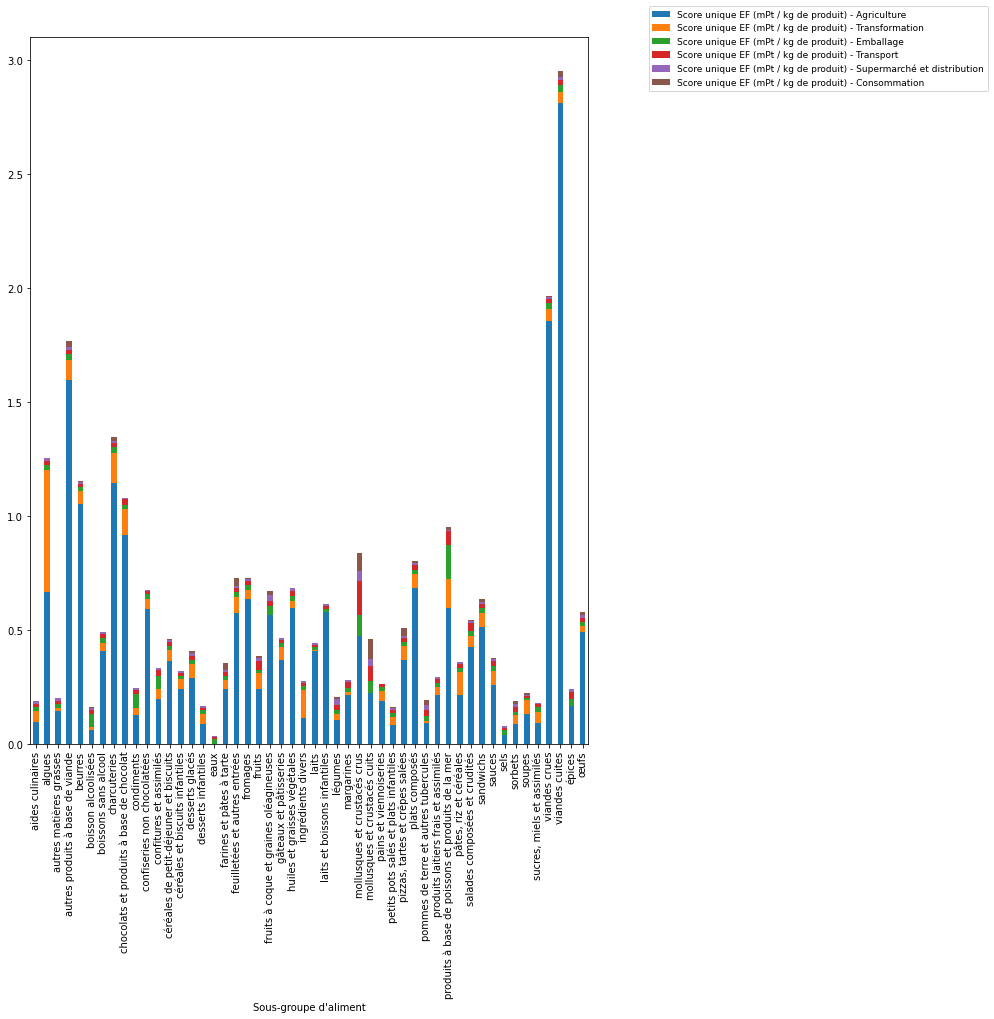

In [14]:
df_etapes_copy = df_etapes.copy()
df_etapes_copy.drop(["DQR", "Score unique EF (mPt / kg de produit)-Moyenne"], axis = "columns", inplace = True)
df_etapes_copy.groupby("Sous-groupe d'aliment").mean().plot(kind="bar",stacked = True, figsize=(10,13)).legend(bbox_to_anchor=(1.1, 1.05),prop = {'size': 9})

L'ensemble des sous-groupes d'aliment ont donc un score unique pour l'agriculture élevé : l'Agriculture tire vers le haut le score unique moyen. C'est donc bien l'étape la plus impactante environnementalement. Ceci nous amènera à nous pencher de plus près sur cette étape par la suite.

On peut donc supposer que l'agriculture est donc l'étape la plus polluante pour les sous-groupes d'aliments au plus fort score unique moyen. Déterminons-les :

In [15]:
df_etapes_fort_impact = df_etapes.sort_values("Score unique EF (mPt / kg de produit)-Moyenne", ascending = False)
df_etapes_fort_impact.head(5)

,Sous-groupe d'aliment,Nom du Produit en Français,Score unique EF (mPt / kg de produit)-Moyenne,Score unique EF (mPt / kg de produit) - Agriculture,Score unique EF (mPt / kg de produit) - Transformation,Score unique EF (mPt / kg de produit) - Emballage,Score unique EF (mPt / kg de produit) - Transport,Score unique EF (mPt / kg de produit) - Supermarché et distribution,Score unique EF (mPt / kg de produit) - Consommation,DQR
9,viandes cuites,"Agneau, collier, braisé ou bouilli",1.016084,5.976579,0.013313,0.027925,0.024134,0.014123,0.040431,2.65
336,autres produits à base de viande,Brochette d'agneau,1.013500,5.976579,0.016769,0.022340,0.019680,0.011298,0.034335,2.80
12,viandes cuites,"Agneau, côte filet, grillée/poêlée",1.012773,5.979301,0.013723,0.027925,0.024302,0.014123,0.017267,2.65
19,viandes cuites,"Agneau, épaule, maigre, rôtie/cuite au four",0.813199,4.781264,0.010650,0.022340,0.019307,0.011298,0.034335,2.65
16,viandes cuites,"Agneau, côtelette, grillée",0.809888,4.783985,0.011060,0.022340,0.019475,0.011298,0.011170,2.65



Les viandes cuites restent le sous-groupe à plus fort impact environnemental d'après le score unique moyen. Il s'agit désormais de mesurer la part de l'agriculture dans son score unique moyen :

In [ ]:
df_etapes_viandescuites = df_etapes_copy[df_etapes_copy["Sous-groupe d'aliment"]=="viandes cuites"]
df_etapes_viandescuites_graph = df_etapes_viandescuites.mean().plot.pie(subplots=True, autopct='%.2f', fontsize=30, figsize=(20, 30))


La part du score unique de l'agriculture dans le score unique moyen des viandes cuites est donc de 95%. Le plus grand enjeu environnemental se situe donc à cette étape et peut expliquer "leur sur-impact" sur l'environnement. Nous pouvons donc supposer que les principaux impacts naissent dès la culture des produits étudiés et que de là se rajoutent des effets environnementaux négligeables en comparaison lors des étapes de transformation, d'emballage, de transport ou encore de distibution/consommation.

Si nous prenons le étudié précédemment tel que le tajine de mouton (cas intéressant parce que le mouton est comparable à l'agneau, une viande cuite qui a été indentifiée comme très impactante), à nouveau il est intéressant que l'étape agriculture se démarque :

In [16]:
df_etapes_tajine = df_etapes[df_etapes["Nom du Produit en Français"] == "Tajine de mouton"]
df_etapes_tajine

,Sous-groupe d'aliment,Nom du Produit en Français,Score unique EF (mPt / kg de produit)-Moyenne,Score unique EF (mPt / kg de produit) - Agriculture,Score unique EF (mPt / kg de produit) - Transformation,Score unique EF (mPt / kg de produit) - Emballage,Score unique EF (mPt / kg de produit) - Transport,Score unique EF (mPt / kg de produit) - Supermarché et distribution,Score unique EF (mPt / kg de produit) - Consommation,DQR
2298,plats composés,Tajine de mouton,0.539449,3.14623,0.042005,0.016119,0.016917,0.008979,0.006442,2.62


Le score unique de l'étape agriculture tire à nouveau vers le haut le score unique moyen... Comment expliquer que l'Agriculture a autant d'impact aujourd'hui sur le score unique des groupes d'aliment ? Penchons-nous donc désormais sur l'étape Agriculture en particulier.

**Limites de l'étude jusqu'ici :**

* on suppose que l'impact environnemental d'un plat ou d'une recette peut résulter grossièrement de la somme de l'impact de chaque aliment, lui-même déterminé à parti de la somme du coefficient de chaque indicateur. Or rien ne dit que les effets sont linéaires et s'ajoutent tel quel.
* difficile de retracer le chemin de l'aliment (grande diversité d'agneaux par exemple) et donc d'estimer précisément à partir de l'agriculture les déterminantes de l'impact au niveau de la synthèse

## 5) Tableaux agriculture

*Quel est le plus gros pb environnemental causé par l’agriculture ? Regarder par catégorie d’aliment Quel type de pratique agricole impacte le plus l’environnement ? Quelles différences entre bio et non-bio ?*

### a) Produits non-bio


Maintenant que nous avons une idée des impacts moyens engendrés par l'agriculture de nos aliments, recentrons nos analyses sur les catégories (viandes bovines, porcines, poissons, légumes, etc). Quelles sont celles qui ont un plus fort impact. Engendrent-elles des conséquences sur nos indicateurs dans les memes proportions ?

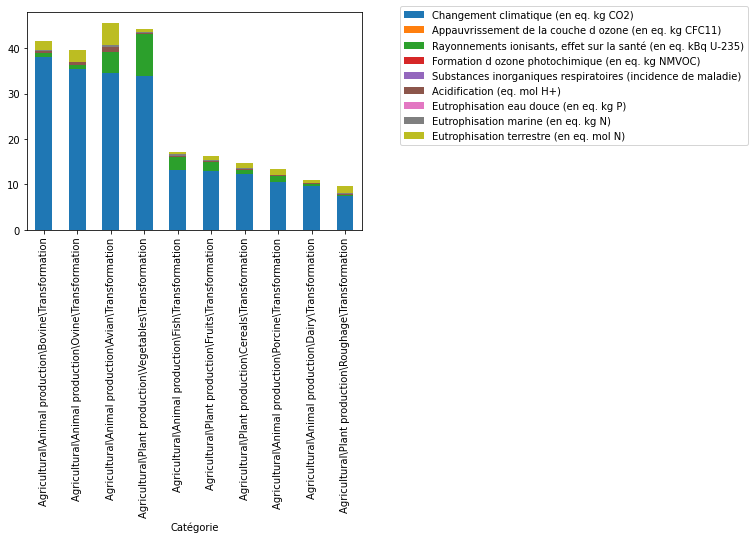

In [17]:
df_agri_nonbio.groupby("Catégorie").sum().sort_values('Changement climatique (en eq. kg CO2)', ascending = False).head(10).plot(kind="bar", stacked = True).legend(bbox_to_anchor=(1.1,1.05))


Nous pouvons tirer deux observations de ce graphique : la première c'est que deux groupes se distinguent particulièrement (la viande bovine, ovie et aviane ainsi que que les légumes en "gros pollueurs", les autres plus bas).La seconde est le large impact en rayonnements ionisants et effets sur la santé provoqué par l'agriculture des légumes.

Concentrons nous désormais sur le changement climatique, sachant que cet indicateur est répertorié comme le plus robustes par Agribalyse.

,Nom du produit,Changement climatique (en eq. kg CO2)
17,Génisse allaitante système d'engraissement co...,20.9806
31,"Agneau système de production conventionnel, à ...",19.5897
16,"Boeuf, moyenne nationale, à la de la ferme / ...",16.9856
32,"Agneau, conventionnel, système Roquefort, à la...",5.28971
34,"Laine, conventionnel, système Roquefort, à la ...",5.22663
...,...,...
200,"Oignon conventionnel, jour court semé, à la fe...",0.0540012
199,"Oignon conventionnel, moyenne nationale, à la ...",0.0539465
198,"Oignon conventionnel, jour long semé, à la fer...",0.0453794
164,"Carotte conventionnelle de saison, avec l'empr...",0.0426529


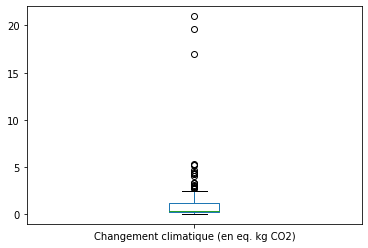

In [18]:
df_agri_nonbio_changement_climatique = df_agri_nonbio[["Nom du produit",'Changement climatique (en eq. kg CO2)']].sort_values('Changement climatique (en eq. kg CO2)', ascending = False)
df_agri_nonbio_changement_climatique
df_agri_nonbio_changement_climatique.plot(kind='box')


La distribution est assez concentrée autour de faibles valeurs, mais quelques valeurs extrêmes beaucoup plus hautes sont repérables (comme pour les donneés sur l'impact des viandes dans le tableau de synthèse)

In [19]:
df_agri_nonbio_cat= df_agri_nonbio[["Catégorie","Changement climatique (en eq. kg CO2)"]].groupby(by = 'Catégorie').sum().sort_values('Changement climatique (en eq. kg CO2)', ascending = False).copy()
df_agri_nonbio_cat

,Changement climatique (en eq. kg CO2)
Catégorie,
Agricultural\Animal production\Bovine\Transformation,37.966201
Agricultural\Animal production\Ovine\Transformation,35.312712
Agricultural\Animal production\Avian\Transformation,34.620173
Agricultural\Plant production\Vegetables\Transformation,33.896703
Agricultural\Animal production\Fish\Transformation,13.113198
Agricultural\Plant production\Fruits\Transformation,12.977493
Agricultural\Plant production\Cereals\Transformation,12.383102
Agricultural\Animal production\Porcine\Transformation,10.589155
Agricultural\Animal production\Dairy\Transformation,9.630046


Sans surprise, c'est encore la viande qui occupe le haut du podium. Cependant, on observe en quatrieme position les légumes ("Vegetable"), impactant le changement climatique fincipalement du fait de leur transformation agricole. 

Inversement, les produits de la pêche européenne figurent en bas du classement.

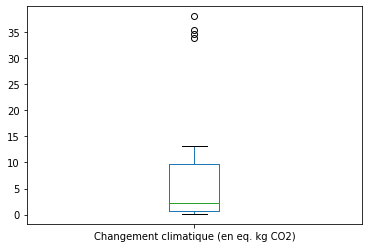

In [20]:
df_agri_nonbio_cat.plot(kind='box')

Ici, les données sont moins ramassé vers le bas. Mais il y a une constante : certains produits se détachent clairement du reste vers le haut du classement. C'est d'ailleurs ce qu'on retrouve dans le graphique ci-après entre les 4 premières catégories d'aliments et le reste. 

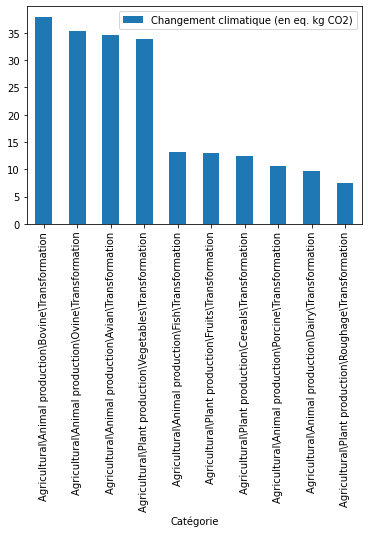

In [21]:
df_agri_nonbio_cat.head(10).plot(kind='bar', stacked = True)

### b) Produits issus de l'agriculture biologique

On procède exactement de la même façon pour les produits biologiques.

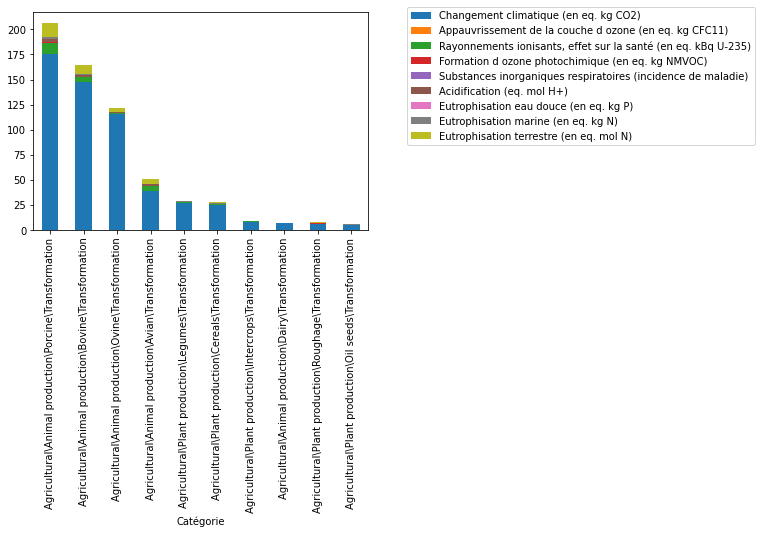

In [22]:

df_agri_bio.groupby("Catégorie").sum().sort_values('Changement climatique (en eq. kg CO2)', ascending = False).head(10).plot(kind="bar", stacked = True).legend(bbox_to_anchor=(1.1,1.05))


Ici, la viande est toujours en tête, mais cette fois ci, il apparait que les légumes n'ont aucun effet sur les rayonnements ionisants

In [23]:
df_agri_bio_changement_climatique = df_agri_bio[["Nom du produit",'Changement climatique (en eq. kg CO2)']].sort_values('Changement climatique (en eq. kg CO2)', ascending = False).head(10)
df_agri_bio_changement_climatique

,Nom du produit,Changement climatique (en eq. kg CO2)
41,"Réforme truie, biologique, système n ° 3, à la...",59.8712
42,"Réforme truie, biologique, système n ° 4, à la...",39.5717
33,"Lamb, biologique, système n ° 3, à la ferme / ...",25.3612
30,"Réforme brebis, biologique, système n ° 3, à l...",20.6825
29,"Réforme brebis, biologique, système n ° 2, à l...",17.9928
18,"vache Réforme, biologique, système n ° 2, à la...",17.8022
17,"vache Réforme, biologique, système n ° 1, à la...",17.0603
10,"Veau, 13 jours, biologique, plaine système de ...",16.0572
31,"Lamb, biologique, système n ° 1, à la ferme / ...",15.0398
38,"truie Réforme, moyenne biologique, national, à...",13.0708


Encore une fois, c'est la viande qui a le plus grand impact. On distingue pourtant ici des produtis spécifique : la truie, la brebis, la vache, le veau et l'agneau.

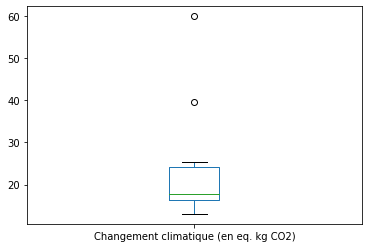

In [24]:
df_agri_bio_changement_climatique.plot(kind='box')

Ce diagramme montre que, cette fois ci, les données sont plus réparties meme ci un produit se détachent négativement sur reste : la truie. 

Comme précedemment, regroupons les catégorie pour adopter une vue d'ensemble 

In [25]:
df_agri_bio_cat= df_agri_bio[["Catégorie","Changement climatique (en eq. kg CO2)"]].groupby(by = 'Catégorie').sum().sort_values('Changement climatique (en eq. kg CO2)', ascending = False).copy()
df_agri_bio_cat

,Changement climatique (en eq. kg CO2)
Catégorie,
Agricultural\Animal production\Porcine\Transformation,175.015114
Agricultural\Animal production\Bovine\Transformation,147.492058
Agricultural\Animal production\Ovine\Transformation,115.679525
Agricultural\Animal production\Avian\Transformation,38.542715
Agricultural\Plant production\Legumes\Transformation,26.788471
Agricultural\Plant production\Cereals\Transformation,24.765599
Agricultural\Plant production\Intercrops\Transformation,8.398198
Agricultural\Animal production\Dairy\Transformation,6.451675
Agricultural\Plant production\Roughage\Transformation,6.123840


Sans surprise, la viande porcine prend la tête du classement, et les fruits et légumes ferment la marche. Encore une fois, le trio animal de tete est largement pire en terme de changement climatique que ses camarades, chose que nous retrouvons dans les graphiques ci après. 

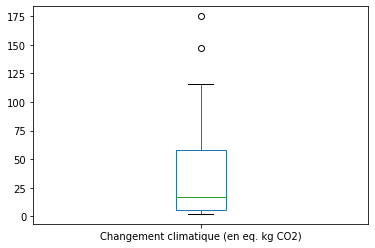

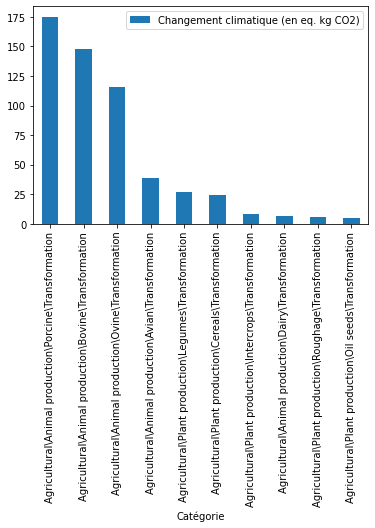

In [27]:
df_agri_bio_cat.plot(kind='box')
df_agri_bio_cat.head(10).plot(kind='bar', stacked = True)

### c) Comparaison bio/ non bio

,Changement climatique (en eq. kg CO2),Appauvrissement de la couche d ozone (en eq. kg CFC11),"Rayonnements ionisants, effet sur la santé (en eq. kBq U-235)",Formation d ozone photochimique (en eq. kg NMVOC),Substances inorganiques respiratoires (incidence de maladie),Acidification (eq. mol H+),Eutrophisation eau douce (en eq. kg P),Eutrophisation marine (en eq. kg N),Eutrophisation terrestre (en eq. mol N)
0,1.049320,9.521967e-08,0.108562,0.005163,1.636942e-07,0.019641,0.000317,0.008636,0.079397
1,2.584709,8.166867e-08,0.127420,0.004708,2.514717e-07,0.038240,0.000402,0.020040,0.169300


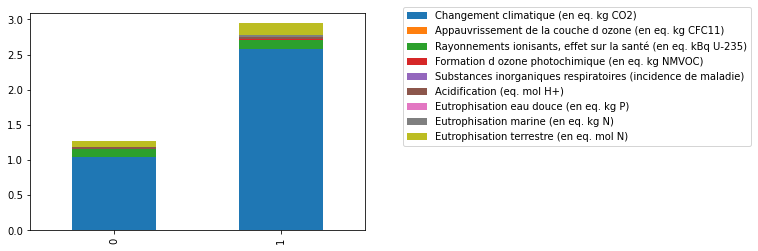

In [28]:
df_new_line_bio = pd.DataFrame([df_agri_bio.mean()], columns = ["Changement climatique (en eq. kg CO2)","Appauvrissement de la couche d ozone (en eq. kg CFC11)","Rayonnements ionisants, effet sur la santé (en eq. kBq U-235)","Formation d ozone photochimique (en eq. kg NMVOC)","Substances inorganiques respiratoires (incidence de maladie)","Acidification (eq. mol H+)","Eutrophisation eau douce (en eq. kg P)","Eutrophisation marine (en eq. kg N)","Eutrophisation terrestre (en eq. mol N)"])
df_new_line_nonbio = pd.DataFrame([df_agri_nonbio.mean()], columns = ["Changement climatique (en eq. kg CO2)","Appauvrissement de la couche d ozone (en eq. kg CFC11)","Rayonnements ionisants, effet sur la santé (en eq. kBq U-235)","Formation d ozone photochimique (en eq. kg NMVOC)","Substances inorganiques respiratoires (incidence de maladie)","Acidification (eq. mol H+)","Eutrophisation eau douce (en eq. kg P)","Eutrophisation marine (en eq. kg N)","Eutrophisation terrestre (en eq. mol N)"])
df_comparaison = pd.concat([df_new_line_nonbio,df_new_line_bio],ignore_index= True)
df_comparaison
df_comparaison.plot(kind='bar', stacked = True).legend(bbox_to_anchor=(1.1,1.05))

On observe un résultat étrange: les produits bio ont en moyenne un impact supérieur ! Hypothèse : comme les produits étudiés ne sont pas les mêmes dans les deux tableaux, il y a sans doute un biais de sélection (pour les produits bios, il s'agit sans doute de produits qui ont globalement un impact supérieur qu'ils soient bios ou non, aux produits non-bio étudiés), qui explique ce résultat contre-intuitif, mais qui interdit d'y voir un effet causal (qui signifierait que ce serait parce qu'ils sont bio que les produits polluent, ce qui est absurde).

**Retour sur un plat cuisiné : le tajine de mouton**

Regardons plus en détail l'empreinte agricole du tajine de mouton. D'après le tableau des ingrédients ci-dessus, le Tajine est composé de viande d'agneau, d'huile d'olive, d'oignons, de tomates, d'olives, de courgettes, de sucre blanc et de miel.

Nous allons comparer tajine non biologique et tajine biologique.


In [29]:
df_agri_tajine_nonbio = pd.concat([df_agri_nonbio[df_agri_nonbio["Nom du produit"]=="Agneau, conventionnel, système Roquefort, à la ferme / FR U"],df_agri_nonbio[df_agri_nonbio["Nom du produit"]=="Oignon conventionnel, moyenne nationale, à la ferme / FR U"],df_agri_nonbio[df_agri_nonbio["Nom du produit"]=="Tomate conventionnelle, panier moyen, serre chauffée, moyenne nationale, à la ferme / FR U"],df_agri_nonbio[df_agri_nonbio["Nom du produit"]=="Courgette conventionnelle, moyenne nationale, à la ferme / FR U"]])
df_agri_tajine_nonbio

,Nom du produit,Catégorie,Changement climatique (en eq. kg CO2),Appauvrissement de la couche d ozone (en eq. kg CFC11),"Rayonnements ionisants, effet sur la santé (en eq. kBq U-235)",Formation d ozone photochimique (en eq. kg NMVOC),Substances inorganiques respiratoires (incidence de maladie),Acidification (eq. mol H+),Eutrophisation eau douce (en eq. kg P),Eutrophisation marine (en eq. kg N),Eutrophisation terrestre (en eq. mol N)
32,"Agneau, conventionnel, système Roquefort, à la...",Agricultural\Animal production\Ovine\Transform...,5.28971,1.15332e-07,0.249992,0.00590815,7.1411e-07,0.104666,0.000245465,0.0215262,0.464752
199,"Oignon conventionnel, moyenne nationale, à la ...",Agricultural\Plant production\Vegetables\Trans...,0.0539465,1.16202e-08,0.038109,0.000337185,3.9524e-09,0.000678278,3.5755e-05,0.00154375,0.00229033
212,"Tomate conventionnelle, panier moyen, serre ch...",Agricultural\Plant production\Vegetables\Trans...,2.36228,3.98625e-07,0.202376,0.00329812,5.61111e-08,0.00569136,0.000566563,0.00278114,0.0130372
202,"Courgette conventionnelle, moyenne nationale, ...",Agricultural\Plant production\Vegetables\Trans...,0.146887,1.69283e-08,0.0276366,0.000855528,8.33909e-09,0.00149362,4.11995e-05,0.00121632,0.00680692


In [30]:
df_agri_tajine_bio = pd.concat([df_agri_bio[df_agri_bio["Nom du produit"]=="Lamb, biologique, système n ° 1, à la ferme / FR U"],df_agri_nonbio[df_agri_nonbio["Nom du produit"]=="Oignon conventionnel, moyenne nationale, à la ferme / FR U"],df_agri_bio[df_agri_bio["Nom du produit"]=="Tomate, biologique, la production à effet de serre, la moyenne nationale, à effet de serre / FR U"],df_agri_bio[df_agri_bio["Nom du produit"]=="Courge, printemps, sous tunnel, porte biologique, à la ferme / FR U"]])
df_agri_tajine_bio

,Nom du produit,Catégorie,Changement climatique (en eq. kg CO2),Appauvrissement de la couche d ozone (en eq. kg CFC11),"Rayonnements ionisants, effet sur la santé (en eq. kBq U-235)",Formation d ozone photochimique (en eq. kg NMVOC),Substances inorganiques respiratoires (incidence de maladie),Acidification (eq. mol H+),Eutrophisation eau douce (en eq. kg P),Eutrophisation marine (en eq. kg N),Eutrophisation terrestre (en eq. mol N)
31,"Lamb, biologique, système n ° 1, à la ferme / ...",Agricultural\Animal production\Ovine\Transform...,15.0398,2.3292e-07,0.11931,0.0176732,7.48907e-07,0.115401,0.000622138,0.0763973,0.516235
199,"Oignon conventionnel, moyenne nationale, à la ...",Agricultural\Plant production\Vegetables\Trans...,0.0539465,1.16202e-08,0.038109,0.000337185,3.9524e-09,0.000678278,3.5755e-05,0.00154375,0.00229033
219,"Tomate, biologique, la production à effet de s...",Agricultural\Plant production\Vegetables\Trans...,0.205365,2.39061e-08,0.0455336,0.000673468,1.04074e-08,0.00174245,4.16843e-05,0.000338623,0.00879566
218,"Courge, printemps, sous tunnel, porte biologiq...",Agricultural\Plant production\Vegetables\Trans...,0.161423,1.6041e-08,0.0419865,0.000773917,9.47409e-09,0.00171381,3.80417e-05,0.00051385,0.00914471


*remarque : pour le tajine bio, nous avons bien sélectionné les mêmes aliments en version bio, hormis les oignons que nous avons repris dans le tableau non bio à défaut de les avoir trouvé dans le tableau bio*

,Changement climatique (en eq. kg CO2),Appauvrissement de la couche d ozone (en eq. kg CFC11),"Rayonnements ionisants, effet sur la santé (en eq. kBq U-235)",Formation d ozone photochimique (en eq. kg NMVOC),Substances inorganiques respiratoires (incidence de maladie),Acidification (eq. mol H+),Eutrophisation eau douce (en eq. kg P),Eutrophisation marine (en eq. kg N),Eutrophisation terrestre (en eq. mol N)
0,1.963206,1.356262e-07,0.129528,0.002600,1.956281e-07,0.028132,0.000222,0.006767,0.121722
1,3.865129,7.112185e-08,0.061235,0.004864,1.931851e-07,0.029884,0.000184,0.019698,0.134116


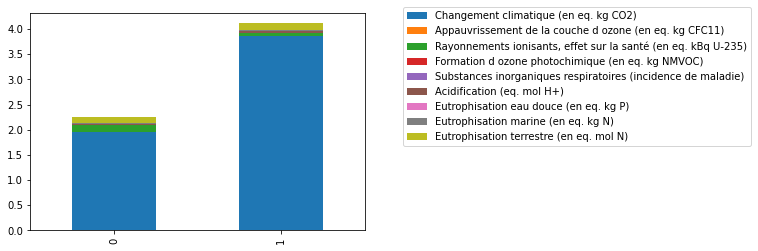

In [31]:
df_n_line_bio = pd.DataFrame([df_agri_tajine_bio.mean()], columns = ["Changement climatique (en eq. kg CO2)","Appauvrissement de la couche d ozone (en eq. kg CFC11)","Rayonnements ionisants, effet sur la santé (en eq. kBq U-235)","Formation d ozone photochimique (en eq. kg NMVOC)","Substances inorganiques respiratoires (incidence de maladie)","Acidification (eq. mol H+)","Eutrophisation eau douce (en eq. kg P)","Eutrophisation marine (en eq. kg N)","Eutrophisation terrestre (en eq. mol N)"])
df_n_line_nonbio = pd.DataFrame([df_agri_tajine_nonbio.mean()], columns = ["Changement climatique (en eq. kg CO2)","Appauvrissement de la couche d ozone (en eq. kg CFC11)","Rayonnements ionisants, effet sur la santé (en eq. kBq U-235)","Formation d ozone photochimique (en eq. kg NMVOC)","Substances inorganiques respiratoires (incidence de maladie)","Acidification (eq. mol H+)","Eutrophisation eau douce (en eq. kg P)","Eutrophisation marine (en eq. kg N)","Eutrophisation terrestre (en eq. mol N)"])
df_compa_tajine= pd.concat([df_n_line_nonbio,df_n_line_bio],ignore_index= True)
df_compa_tajine
df_compa_tajine.plot(kind='bar', stacked = True).legend(bbox_to_anchor=(1.1,1.05))

Encore une fois, les résultats sont étonnants : l'impacte sur le changement climatique du tajine bio est largement supérieur à celui du tajine non bio, la différence se faisant sur l'agneau (impact_nonbio = 5 < impact_bio = 15)

Heureusement, les nouvelles ne sont pas que négatives: les effets sur le rayonnemant ionistants et la santé sont tout de même largement inférieur pour le tajine bio que pour celui non bio. 